In [243]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

from helpers.makemore_helpers import make_char2idx_map, build_dataset

words = open(r'data\names.txt','r').read().splitlines()
char2idx = make_char2idx_map(words)
idx2char = {v: k for k, v in char2idx.items()}

block_size = 8

In [295]:
train_count = int(len(words) * 0.8)
n_1 = int(len(words) * 0.9)

x_train, y_train = build_dataset(words[:train_count], block_size, char2idx)
x_val, y_val = build_dataset(words[train_count:n_1], block_size, char2idx)
x_test, y_test = build_dataset(words[n_1:], block_size, char2idx)

total_train = len(x_train)
total_val = len(x_val)
total_test = len(x_test)

print(f"Sizes:", total_train, total_val, total_test)
print("Shapes:", x_train.shape, y_train.shape)

# x_train.to('cuda')
# y_train.to('cuda')

Sizes: 182778 22633 22735
Shapes: torch.Size([182778, 8]) torch.Size([182778])


In [296]:
from __future__ import  annotations

class Linear:
    def __init__(self,fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + [self.bias] if self.bias is not None else [self.weight]



class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


class BatchNorm:
    def __init__(self, fan_out, eps=1e-5, momentum=0.01):
        self.eps = eps
        self.momentum = momentum

        self.training = True

        # trainable parameters
        self.scale_by = torch.ones(fan_out)
        self.shift_by = torch.zeros(fan_out)

        # buffers
        self.running_mean = torch.zeros(fan_out)
        self.running_var = torch.ones(fan_out)

    def __call__(self, x):
        if self.training:
            # The batch norm assumes that x is 2d. But if its 3d we have calculate the mean and variance over the first two dimensions
            dim = None # so that it throws an error if x.ndim is not 2 or 3
            if x.ndim == 3:
                dim = (0, 1)
            elif x.ndim == 2:
                dim = 0

            mean = x.mean(dim, keepdim=True)
            var = x.var(dim, keepdim=True, unbiased=True)

            with torch.no_grad():
                self.running_mean = self.momentum * mean + (1 - self.momentum) * self.running_mean
                self.running_var = self.momentum * var + (1 - self.momentum) * self.running_var
        else:
            mean = self.running_mean
            var = self.running_var

        x_hat = (x - mean) / (var + self.eps).sqrt()
        self.out = self.scale_by * x_hat + self.shift_by

        return self.out

    def parameters(self):
        return [self.scale_by, self.shift_by]


class Embedding:
    def __init__(self, embedding_size, embedding_dimension):
        self.weight = torch.randn((embedding_size, embedding_dimension))

    def __call__(self, x):
        self.out = self.weight[x]
        return self.out

    def parameters(self):
        return [self.weight]

class FlattenConsecutive:
    def __init__(self, n_consecutive):
        self.n_consecutive = n_consecutive

    def __call__(self, x):
        batch, seq_len, rest = x.shape

        x = x.view(batch, seq_len // self.n_consecutive, self.n_consecutive * rest)   
        if x.shape[1] == 1:
            x = x.squeeze(1)

        self.out = x
        return self.out

    def parameters(self):
        return []


class Sequential:
    def __init__(self, *layers: list):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [297]:
embedding_size = 24
vocab_size = len(char2idx)
hidden_size = 128

model = Sequential(
    Embedding(vocab_size, embedding_size),
    FlattenConsecutive(2),Linear(embedding_size * 2, hidden_size, bias=False), BatchNorm(hidden_size), Tanh(),
    FlattenConsecutive(2),Linear(hidden_size * 2, hidden_size, bias=False), BatchNorm(hidden_size), Tanh(),
    FlattenConsecutive(2),Linear(hidden_size * 2, hidden_size, bias=False), BatchNorm(hidden_size), Tanh(),
    Linear(hidden_size, vocab_size),
)


with torch.no_grad():
    # make softmax layer less confident
    layers[-1].weight *= 0.1


params = model.parameters()
print("Total parameters:", sum(p.numel() for p in params))

for p in params:
    p.to('cuda')
    p.requires_grad = True
    


Total parameters: 76579


In [298]:
torch.version.cuda

'11.6'

In [299]:
# Scratchpad to see the internal state of the model
ix = torch.randint(0,total_train, (4,))
xs, ys = x_train[ix], y_train[ix]
logits = model(xs)


for layer in model.layers:
    if hasattr(layer, "out"):
        print(f"{layer.__class__.__name__} : {tuple(layer.out.shape)}")




Embedding : (4, 8, 24)
FlattenConsecutive : (4, 4, 48)
Linear : (4, 4, 128)
BatchNorm : (4, 4, 128)
Tanh : (4, 4, 128)
FlattenConsecutive : (4, 2, 256)
Linear : (4, 2, 128)
BatchNorm : (4, 2, 128)
Tanh : (4, 2, 128)
FlattenConsecutive : (4, 256)
Linear : (4, 128)
BatchNorm : (4, 128)
Tanh : (4, 128)
Linear : (4, 27)


In [300]:
steps = 100_000
batch_size = 128
losses = []
# lrs_used = []

update_to_data = []

for step in range(steps):

    # mini-batch
    batch_idx = torch.randint(0,total_train, (batch_size,))
    xs = x_train[batch_idx]
    ys = y_train[batch_idx]
    
    xs.to('cuda')
    ys.to('cuda')
    
    # Forward pass
    logits = model(xs)

    # Loss
    loss = F.cross_entropy(logits, ys)

    # Backward pass
    for p in params:
        p.grad = None

    loss.backward()

    lr = 0.1 if step < int(0.6*steps) else 0.01
    for p in params:
        p.data += -lr * p.grad


    if step % 1000 == 0:
        print(f"Step {step:6d}: loss {loss.item():.4f}")

    
    # tracking
    losses.append(loss.log10().item())
    


Step      0: loss 3.4538
Step   1000: loss 2.0647
Step   2000: loss 1.9809
Step   3000: loss 1.9325
Step   4000: loss 1.9019
Step   5000: loss 1.8652
Step   6000: loss 1.9582
Step   7000: loss 2.2229
Step   8000: loss 2.1166
Step   9000: loss 1.9630
Step  10000: loss 1.9447
Step  11000: loss 1.9878
Step  12000: loss 1.8415
Step  13000: loss 1.9075
Step  14000: loss 1.7194
Step  15000: loss 2.0609
Step  16000: loss 1.8960
Step  17000: loss 1.7894
Step  18000: loss 1.8911
Step  19000: loss 1.8620
Step  20000: loss 2.0365
Step  21000: loss 1.9692
Step  22000: loss 1.8806
Step  23000: loss 1.8983
Step  24000: loss 1.7507
Step  25000: loss 1.7421
Step  26000: loss 1.7803
Step  27000: loss 1.8335
Step  28000: loss 1.7734
Step  29000: loss 1.9345
Step  30000: loss 1.7274
Step  31000: loss 1.8276
Step  32000: loss 1.9141
Step  33000: loss 1.6538
Step  34000: loss 1.8961
Step  35000: loss 1.6888
Step  36000: loss 1.5838
Step  37000: loss 1.8087
Step  38000: loss 1.8505
Step  39000: loss 1.8896


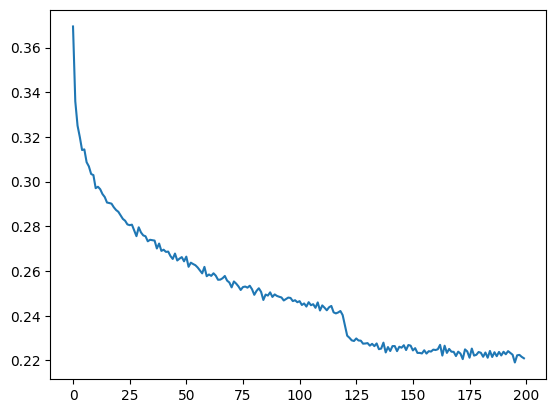

In [305]:
# Each row is 1000 consecutive losses, and we plot their mean
plt.plot(torch.tensor(losses).view(-1,500).mean(1))

In [306]:
for layer in model.layers:
    layer.training = False

In [307]:

@torch.no_grad()
def eval_loss(set_name: str):
    xs, ys = {
        "train": (x_train, y_train),
        "val": (x_val, y_val),
        "test": (x_test, y_test),
    }[set_name]

    logits = model(xs)

    loss = F.cross_entropy(logits, ys)
    print(f"{set_name} loss: {loss.item():.4f}")
    

eval_loss("train")
eval_loss("val")

train loss: 1.6524
val loss: 2.3029


In [308]:
for _ in range(20):
    out = []
    context = [0] * block_size

    while True:
        x = torch.tensor(context).view(1, -1)
        logits = model(x)

        p = F.softmax(logits, dim=1)
        idx = torch.multinomial(p, num_samples=1, replacement=True).item()

        context = context[1:] + [idx]
        if idx == 0:
            break

        out.append(idx)

    print("".join(idx2char[idx] for idx in out))

rhemah
nahid
collynn
shayma
shailey
felicita
gaddie
marifemarum
hage
fraidyn
dallyn
cameran
leilore
milah
sheri
honora
kyia
berkie
anika
diqu
